In [2]:
import os
import timeit
import warnings
from collections import defaultdict
!pip install catboost
!pip install scikit-learn

!pip install scikit-plot

from scikitplot.metrics import plot_confusion_matrix

import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
# from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from termcolor import colored


In [3]:
warnings.filterwarnings('ignore')

np.random.seed(100)
from google.colab import drive
drive.mount('/content/drive')

dataset_root = '/content/drive/My Drive/uva1/nslkdd'

train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

# Original KDD dataset feature names obtained from
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type',
                'success_pred']

Mounted at /content/drive


In [4]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names
# file, but it is supposed to be a binary feature according to the
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

<Axes: ylabel='attack_category'>

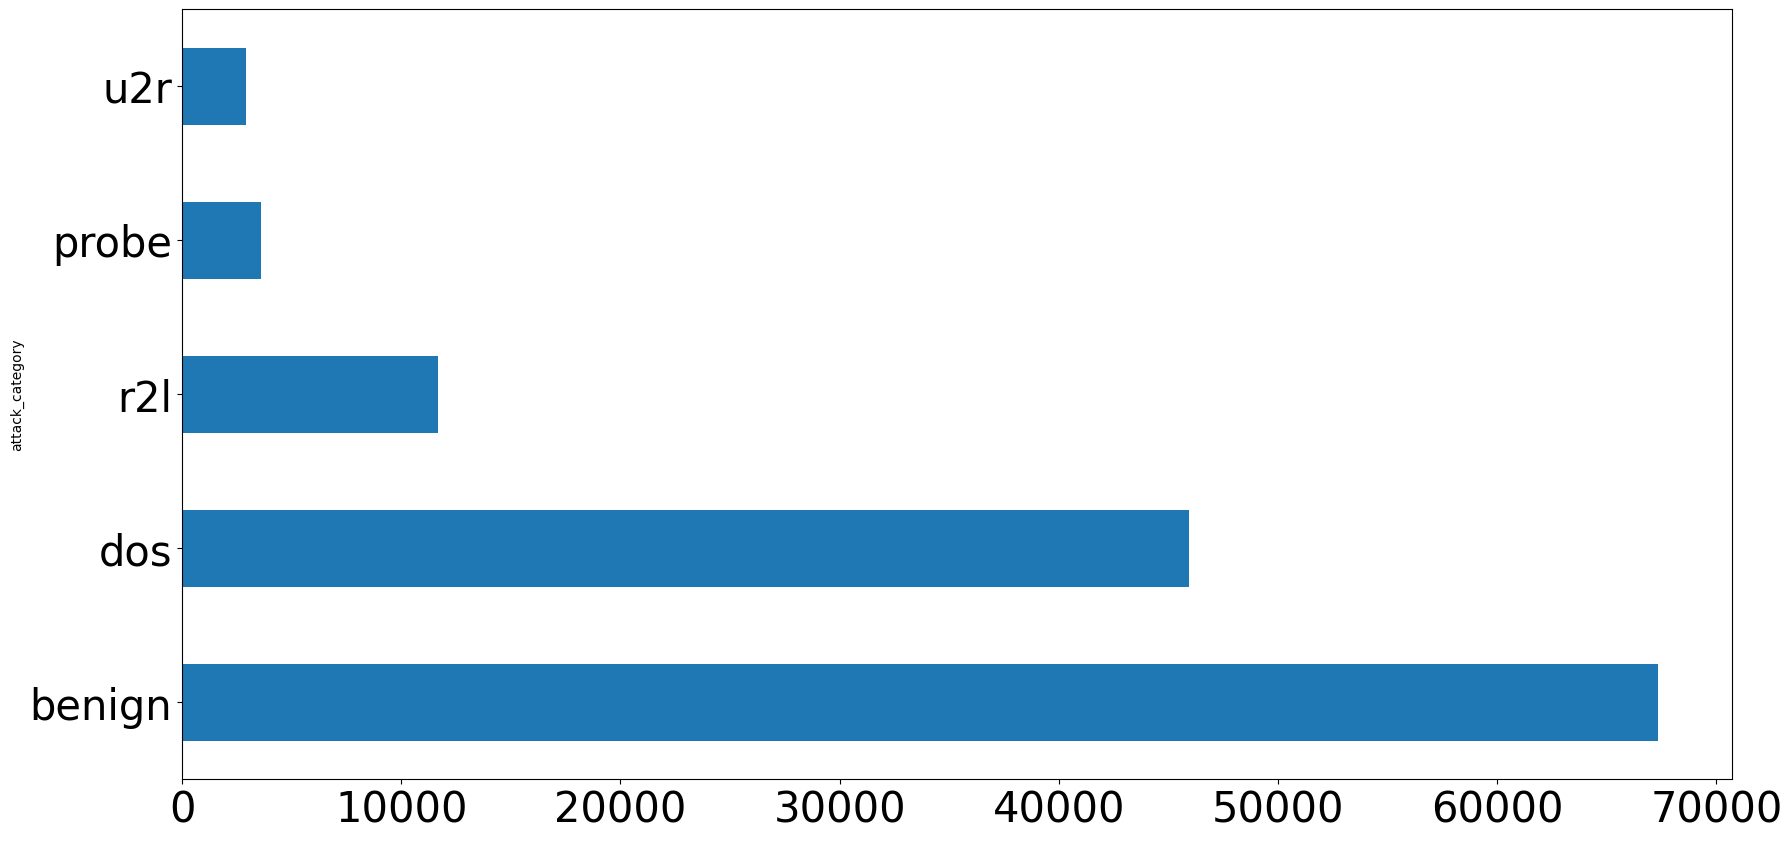

In [5]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types


category = defaultdict(list)
category['benign'].append('normal')

with open('/content/drive/My Drive/uva1/nslkdd/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v, k) for k in category for v in category[k])

train_df = pd.read_csv(train_file, names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
    .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
    .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

test_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=15)

test_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

In [6]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0
# execute the commands in console

train_df[binary_cols].describe().transpose()

# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
# Next, we notice that the num_outbound_cmds column only takes on one value!
print(train_df.columns)


# train_df.groupby(['num_outbound_cmds']).size()

# # Now, that's not a very useful feature - let's drop it from the dataset

# train_df.drop('num_outbound_cmds', axis=1, inplace=True)
# test_df.drop('num_outbound_cmds', axis=1, inplace=True)
# numeric_cols.remove('num_outbound_cmds')


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type', 'attack_category'],
      dtype='object')


In [7]:
"""
Data Preparation

"""
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)

'''# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k=30)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs
'''

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# use this for catboost
x_train = train_x_raw
x_test = test_x_raw

# Store dummy variable feature names
dummy_variables = list(set(train_x) - set(combined_df_raw))

# execute the commands in console
train_x.describe()
train_x['duration'].describe()

# Experimenting with StandardScaler on the single 'duration' feature
durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

'''# transform the dataset
oversample = SMOTE()
train_x, train_Y = oversample.fit_resample(train_x, train_Y)'''

'# transform the dataset\noversample = SMOTE()\ntrain_x, train_Y = oversample.fit_resample(train_x, train_Y)'

In [8]:
"""
multi class classification using decision tree

"""

from sklearn.metrics import accuracy_score, precision_score, recall_score
# Decision Tree
def decision_tree_clf():
    print("------Decision Tree Classification-------")

    # build Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=17)

    # Train Classifier
    classifier.fit(train_x, train_Y)

    # predict
    pred_y = classifier.predict(test_x)

    # confusion matrix
    results = confusion_matrix(test_Y, pred_y)

    # error rate
    error = zero_one_loss(test_Y, pred_y)

    # print results
    print(results)
    print(error)
    # Accuracy
    accuracy = accuracy_score(test_Y, pred_y)

    # Precision
    precision = precision_score(test_Y, pred_y, average='weighted')

    # Recall
    recall = recall_score(test_Y, pred_y, average='weighted')

    # Error Rate
    error = zero_one_loss(test_Y, pred_y)

    # Print results
    print("Confusion Matrix:")
    print(results)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Error Rate:", error)
decision_tree_clf()


------Decision Tree Classification-------
[[9351   59  299    2    0]
 [1417 6125   94    0    0]
 [ 735  187 1501    0    0]
 [2341    4   11  218    0]
 [ 179    0    2    6   13]]
0.23669268985095815
Confusion Matrix:
[[9351   59  299    2    0]
 [1417 6125   94    0    0]
 [ 735  187 1501    0    0]
 [2341    4   11  218    0]
 [ 179    0    2    6   13]]
Accuracy: 0.7633073101490419
Precision: 0.8162789878429526
Recall: 0.7633073101490419
Error Rate: 0.23669268985095815


In [9]:
# answers to question 4
def data_exploration_solution():
    print("*******************")
    print("Step 4: Data Exploration (Understanding the data)")
    print("*******************")
    print("1. Identify the attribute names (Header)")
    print(train_df.columns)
    print("2. Check the length of the Train and Test dataset")
    print("length of Train dataset: ", train_df.size)
    print("length of Test dataset: ", test_df.size)
    print("3. Check the total number of samples that belong to each of the five classes of the training dataset.")
    print(train_df.groupby('attack_category')['flag'].count())
    print("*******************")
data_exploration_solution()

*******************
Step 4: Data Exploration (Understanding the data)
*******************
1. Identify the attribute names (Header)
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type', 'attack_category'],
      dtype='ob

In [10]:
def random_forest_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'n_estimators': [60],
        'criterion': ["gini"],
        'min_samples_split': [2, 4, 6, 10],
        'max_depth': [20, 25, 30],
        # 'max_leaf_nodes': [1, 5, 7, 10]
    }

    # random forest classifer
    clf = RandomForestClassifier()

    print("Searching for optimal parameters..............")

    # Building a 3 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=3)

    print("Training the data...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print(rf_best)

    print(grid_object.best_score_)


# New Section

In [12]:
# Random Forest


def random_forest_clf():
    print(colored("------Random Forest Classification-------", 'red'))
    # build classifier
    clf = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=48, random_state=0)

    # start timer
    start_time = timeit.default_timer()

    print("Training the Random Forest Classifier.......")

    clf = clf.fit(train_x, train_Y)

    # end timer
    print("The time difference is :", timeit.default_timer() - start_time)

    print("Predicting test data.......")

    '''features = clf.feature_importances_
    feature_cols = []
    # print feature importance
    for i, j in enumerate(features, 1):
        if j <= 0.0:
            feature_cols.append(i)
            print(i)
    new_train_x = train_x.copy()
    new_test_x = test_x.copy()

    for k in feature_cols:
        new_train_x.drop(new_train_x.columns[k], axis=1, inplace=True)
        new_test_x.drop(new_test_x.columns[k], axis=1, inplace=True)

    clf2 = RandomForestClassifier(n_estimators=240, random_state=0)
    clf2 = clf2.fit(new_train_x, train_Y)'''

    # predict test data
    pred_y = clf.predict(test_x)

    # analyse prediction
    c_matrix = confusion_matrix(test_Y, pred_y)  # confusion matrix
    error = zero_one_loss(test_Y, pred_y)  # error
    score = accuracy_score(test_Y, pred_y)  # accuracy score

    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # plot_confusion_matrix(clf, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f', xticks_rotation='horizontal')
    # plt.title("Confusion Matrix for Random Forest")
    plt.show()

random_forest_clf()

------Random Forest Classification-------
Training the Random Forest Classifier.......
The time difference is : 10.676628405999963
Predicting test data.......
Confusion Matrix
---------------------------
 [[9458   67  186    0    0]
 [1906 5543  187    0    0]
 [ 750  163 1510    0    0]
 [2529    0    2   41    2]
 [ 193    0    0    4    3]]
---------------------------
Error: 26.5658%
Accuracy Score: 73.4342%
              precision    recall  f1-score   support

      benign       0.64      0.97      0.77      9711
         dos       0.96      0.73      0.83      7636
       probe       0.80      0.62      0.70      2423
         r2l       0.91      0.02      0.03      2574
         u2r       0.60      0.01      0.03       200

    accuracy                           0.73     22544
   macro avg       0.78      0.47      0.47     22544
weighted avg       0.80      0.73      0.69     22544

accuracy:  [0.97394707 0.72590361 0.62319439 0.01592852 0.015     ]


In [13]:
def knn_grid_search():
    # parameters
    grid_params = {
        'n_neighbors': [2, 5, 7, 10, 12],
        'leaf_size': [10, 20, 30, 50, 100]
    }

    # KNN classifier
    clf = KNeighborsClassifier(n_jobs=-1)

    print("Searching for optimal parameters..............")

    # Building a 3 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=10)

    print("Training the data...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print(rf_best)

In [21]:
def find_k():
    # find value for parameter n_neighbors value between 1 to 20 where accuracy is higher
    for i in range(1, 21):
        # KNN classifier
        clf_knn = KNeighborsClassifier(n_neighbors=i)

        # train data
        clf_knn = clf_knn.fit(train_x, train_Y)

        # predict
        pred_y = clf_knn.predict(test_x)

        print('accuracy for k value ', i, ': ', accuracy_score(test_Y, pred_y))


# KNN classifier
def knn_clf():
    print(colored("------KNN Classification-------", 'red'))

    # KNN classifier
    clf_knn = KNeighborsClassifier(n_neighbors=7)  # using 7 because it has higher accuray rate

    # start timer
    starttime = timeit.default_timer()

    print("Training the KNN Classifier.......")

    # Train model
    clf_knn = clf_knn.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_knn.predict(test_x)

    # analyse results
    c_matrix = confusion_matrix(test_Y, pred_y)  # confusion matrix
    error = zero_one_loss(test_Y, pred_y)  # error
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # disp = plot_confusion_matrix(clf_knn, test_x, test_Y, cmap=plt.cm.Greens)
    # plt.title("Confusion Matrix for k-nearest neighbors")

    # plt.show()
knn_clf()


------KNN Classification-------
Training the KNN Classifier.......
The time difference is : 0.6646426449999581
Predicting test data.......
Confusion Matrix
---------------------------
 [[9443   55  210    2    1]
 [1610 5937   89    0    0]
 [ 595  180 1648    0    0]
 [2347    2   53  171    1]
 [ 105    0   85    4    6]]
---------------------------
Error: 23.6826%
Accuracy Score: 76.3174%
              precision    recall  f1-score   support

      benign       0.67      0.97      0.79      9711
         dos       0.96      0.78      0.86      7636
       probe       0.79      0.68      0.73      2423
         r2l       0.97      0.07      0.12      2574
         u2r       0.75      0.03      0.06       200

    accuracy                           0.76     22544
   macro avg       0.83      0.51      0.51     22544
weighted avg       0.82      0.76      0.73     22544

accuracy:  [0.97240243 0.77750131 0.68014858 0.06643357 0.03      ]


In [22]:
# SVM classification
def svc_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'gamma': ['scale', 'auto']
    }

    # SVC estimator
    clf = SVC(random_state=0)

    print("Searching for optimal parameters..............")

    # Building a 3 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=10)

    print("Training the data...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print("Best Parameters are:\n", rf_best)


# SVC
def svm_clf():
    print(colored("------SVM Classification-------", 'red'))
    # build classifier
    clf_svc = SVC(kernel='poly', degree=1, C=3)  # using poly for kernel

    # start timer
    starttime = timeit.default_timer()

    print("Training the SVM Classifier.......")

    # train SVC
    clf_svc = clf_svc.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_svc.predict(test_x)

    # anlayse results
    c_matrix = confusion_matrix(test_Y, pred_y)
    error = zero_one_loss(test_Y, pred_y)
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # disp = plot_confusion_matrix(clf_svc, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f',
    #                              xticks_rotation='horizontal')
    # plt.title("Confusion Matrix for SVM")

    # plt.show()
svm_clf()

------SVM Classification-------
Training the SVM Classifier.......
The time difference is : 185.08966406599984
Predicting test data.......
Confusion Matrix
---------------------------
 [[9112  423  168    7    1]
 [1511 6112   13    0    0]
 [ 733  112 1578    0    0]
 [2299    4    2  269    0]
 [ 191    0    0    4    5]]
---------------------------
Error: 24.2548%
Accuracy Score: 75.7452%
              precision    recall  f1-score   support

      benign       0.66      0.94      0.77      9711
         dos       0.92      0.80      0.86      7636
       probe       0.90      0.65      0.75      2423
         r2l       0.96      0.10      0.19      2574
         u2r       0.83      0.03      0.05       200

    accuracy                           0.76     22544
   macro avg       0.85      0.50      0.52     22544
weighted avg       0.81      0.76      0.73     22544

accuracy:  [0.93831737 0.80041907 0.65125877 0.1045066  0.025     ]


In [23]:
# logistic regression hyperparameter tuning
def logistic_reg_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'penalty': ['l1', 'l2'],
        'max_iter': [100, 200, 300, 500, 800, 1000]
    }

    # logistic regression classifier
    clf = LogisticRegression(random_state=0)

    print("Searching for optimal parameters..............")

    # Building a 10 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=10)

    print("Training the model...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print(rf_best)

In [25]:
# Logistic Regression
def logistic_reg_clf():
    print(colored("------Logistic Regression Classification-------", 'red', attrs='bold'))
    # logistic regression classifier
    clf_lr = LogisticRegression(C=1e5, random_state=0)

    # start timer
    starttime = timeit.default_timer()

    print("Training the Logistic Regression Classifier.......")

    # train the model
    clf_lr = clf_lr.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_lr.predict(test_x)

    # get results
    c_matrix = confusion_matrix(test_Y, pred_y)
    error = zero_one_loss(test_Y, pred_y)
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # disp = plot_confusion_matrix(clf_lr, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f',
    #                              xticks_rotation='horizontal')
    # plt.title("Confusion Matrix for Logistic Regression")

    # plt.show()

logistic_reg_clf()

------Logistic Regression Classification-------
Training the Logistic Regression Classifier.......
The time difference is : 20.89249995499995
Predicting test data.......
Confusion Matrix
---------------------------
 [[8982   93  631    2    3]
 [1560 6055   21    0    0]
 [ 484   92 1842    5    0]
 [2522    2    1   49    0]
 [ 183    3    0    2   12]]
---------------------------
Error: 24.8581%
Accuracy Score: 75.1419%
              precision    recall  f1-score   support

      benign       0.65      0.92      0.77      9711
         dos       0.97      0.79      0.87      7636
       probe       0.74      0.76      0.75      2423
         r2l       0.84      0.02      0.04      2574
         u2r       0.80      0.06      0.11       200

    accuracy                           0.75     22544
   macro avg       0.80      0.51      0.51     22544
weighted avg       0.79      0.75      0.71     22544

accuracy:  [0.92493049 0.79295443 0.76021461 0.01903652 0.06      ]


In [26]:
# hyperparameter tuning for SGD
def sgd_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'loss': ['hinge', 'log'],
        'penalty': ['l2', 'l1'],
        'max_iter': [100, 200, 300, 400, 500],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
    }

    # SGD classifier
    clf = SGDClassifier(random_state=0)

    print("Searching for optimal parameters..............")

    # Building a 10 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=10)

    print("Training the model...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model
    rf_best = grid_object.best_estimator_
    print(rf_best)


# SGD classification

In [27]:
# SGD classification
def sgd_clf():
    print(colored("------SGD Classification-------", 'red'))
    # build classifier
    clf_sgd = SGDClassifier(loss="hinge", penalty="l1", max_iter=200, alpha=0.001, random_state=0)

    # start timer
    starttime = timeit.default_timer()

    print("Training the SGD Classifier.......")

    # train model
    clf_sgd = clf_sgd.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_sgd.predict(test_x)

    c_matrix = confusion_matrix(test_Y, pred_y)
    error = zero_one_loss(test_Y, pred_y)
    score = accuracy_score(test_Y, pred_y)

    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # disp = plot_confusion_matrix(clf_sgd, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f',
    #                              xticks_rotation='horizontal')
    # plt.title("Confusion Matrix for SGD")

    # plt.show()
sgd_clf()


------SGD Classification-------
Training the SGD Classifier.......
The time difference is : 13.772806596999999
Predicting test data.......
Confusion Matrix
---------------------------
 [[9462   87  162    0    0]
 [1705 5915   16    0    0]
 [ 847  126 1450    0    0]
 [2561    0    8    5    0]
 [ 199    0    1    0    0]]
---------------------------
Error: 25.3371%
Accuracy Score: 74.6629%
              precision    recall  f1-score   support

      benign       0.64      0.97      0.77      9711
         dos       0.97      0.77      0.86      7636
       probe       0.89      0.60      0.71      2423
         r2l       1.00      0.00      0.00      2574
         u2r       0.00      0.00      0.00       200

    accuracy                           0.75     22544
   macro avg       0.70      0.47      0.47     22544
weighted avg       0.81      0.75      0.70     22544

accuracy:  [0.97435897 0.77462022 0.5984317  0.0019425  0.        ]


In [28]:
# AdaBoost Grid Search
def adaboost_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {
        'n_estimators': [20, 50, 100, 200, 500, 800],
        'learning_rate': [0.05, 0.8, 1]
    }

    # Adaboost classifier
    clf = AdaBoostClassifier(random_state=0)

    print("Searching for optimal parameters..............")

    # Building a 10 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=10)

    print("Training the model...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model=
    rf_best = grid_object.best_estimator_
    print(rf_best)



In [29]:
# adaboost
def adaboost_clf():
    print(colored("------Adaboost Classification-------", 'red'))
    # define classifier
    clf_abc = AdaBoostClassifier(n_estimators=15, learning_rate=1)

    # time it
    starttime = timeit.default_timer()

    print("Training the Adaboost Classifier.......")

    # fit data
    clf_abc.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    pred_y = clf_abc.predict(test_x)

    # results
    c_matrix = confusion_matrix(test_Y, pred_y)
    error = zero_one_loss(test_Y, pred_y)
    score = accuracy_score(test_Y, pred_y)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, pred_y))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # disp = plot_confusion_matrix(clf_abc, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f',
    #                              xticks_rotation='horizontal')
    # plt.title("Confusion Matrix for AdaBoost")

    # plt.show()

adaboost_clf()

------Adaboost Classification-------
Training the Adaboost Classifier.......
The time difference is : 12.788730474999966
Predicting test data.......
Confusion Matrix
---------------------------
 [[8825  555  331    0    0]
 [1444 4375 1817    0    0]
 [ 190  306 1927    0    0]
 [1937    2  635    0    0]
 [  86    0  114    0    0]]
---------------------------
Error: 32.9001%
Accuracy Score: 67.0999%
              precision    recall  f1-score   support

      benign       0.71      0.91      0.80      9711
         dos       0.84      0.57      0.68      7636
       probe       0.40      0.80      0.53      2423
         r2l       0.00      0.00      0.00      2574
         u2r       0.00      0.00      0.00       200

    accuracy                           0.67     22544
   macro avg       0.39      0.46      0.40     22544
weighted avg       0.63      0.67      0.63     22544

accuracy:  [0.90876326 0.57294395 0.79529509 0.         0.        ]


In [30]:
# Multi-Layer Percepton MLP
def mlp_clf():
    print(colored("------MLP Classification-------", 'red'))

    # Build classifier
    clf_nn = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1000, 5), max_iter=1000, random_state=1)

    print("Training the MLP Classifier.......")

    # start timer
    starttime = timeit.default_timer()  # start timer

    # train
    clf_nn.fit(train_x, train_Y)

    print("The time difference is :", timeit.default_timer() - starttime)

    print("Predicting test data.......")

    # predict
    nn_pred = clf_nn.predict(test_x)

    # results
    c_matrix = confusion_matrix(test_Y, nn_pred)
    error = zero_one_loss(test_Y, nn_pred)
    score = accuracy_score(test_Y, nn_pred)

    # display results
    print('Confusion Matrix\n---------------------------\n', c_matrix)
    print('---------------------------')
    print("Error: {:.4f}%".format(error * 100))
    print("Accuracy Score: {:.4f}%".format(score * 100))
    print(classification_report(test_Y, nn_pred))
    print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

    # Plot non-normalized confusion matrix
    # disp = plot_confusion_matrix(clf_nn, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f',
    #                              xticks_rotation='horizontal')
    # plt.title("Confusion Matrix for Neural Network")

    # plt.show()
mlp_clf()


------MLP Classification-------
Training the MLP Classifier.......
The time difference is : 809.8805868090001
Predicting test data.......
Confusion Matrix
---------------------------
 [[9326   56  322    4    3]
 [1224 6375   36    1    0]
 [ 680  167 1576    0    0]
 [2200    1   50  320    3]
 [ 155    0   18    4   23]]
---------------------------
Error: 21.8417%
Accuracy Score: 78.1583%
              precision    recall  f1-score   support

      benign       0.69      0.96      0.80      9711
         dos       0.97      0.83      0.90      7636
       probe       0.79      0.65      0.71      2423
         r2l       0.97      0.12      0.22      2574
         u2r       0.79      0.12      0.20       200

    accuracy                           0.78     22544
   macro avg       0.84      0.54      0.57     22544
weighted avg       0.83      0.78      0.75     22544

accuracy:  [0.96035424 0.83486118 0.65043335 0.12432012 0.115     ]


In [31]:
# Xgboost grid search
def xgboost_grid_search():
    # Creating a grid of different hyperparameters
    grid_params = {"learning_rate": [0.05, 0.10, 0.2, 0.3],
                   "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                   "n_estimators": [50, 100, 200, 250, 500]
                   }

    # Adaboost classifier
    clf = xgb.XGBClassifier()

    print("Searching for optimal parameters..............")

    # Building a 10 fold Cross-Validated GridSearchCV object
    grid_object = GridSearchCV(estimator=clf, param_grid=grid_params, cv=5, scoring='accuracy', n_jobs=-1)

    print("Training the model...............")

    # Fitting the grid to the training data
    grid_object.fit(train_x, train_Y)

    # Extracting the best parameters
    print(grid_object.best_params_)

    # Extracting the best model=
    rf_best = grid_object.best_estimator_
    print(rf_best)

    print('Best score : ', grid_object.best_score_)



In [33]:
# # xgboost classifier
# def xgboost_clf():
#     print(colored("------XGBoost Classification-------", 'red'))

#     xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                                   colsample_bynode=1, colsample_bytree=1, gamma=1,
#                                   learning_rate=0.2, max_delta_step=0, max_depth=3,
#                                   min_child_weight=1, missing=None, n_estimators=490, n_jobs=-1,
#                                   nthread=None, objective='multi:softprob', random_state=0,
#                                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
#                                   silent=None, subsample=1, verbosity=1)

#     print("Training the XGBoost Classifier.......")

#     # start timer
#     starttime = timeit.default_timer()  # start timer

#     xgb_model.fit(train_x, train_Y)

#     print("The time difference is :", timeit.default_timer() - starttime)

#     print("Predicting test data.......")

#     # print(xgb_model.feature_importances_)

#     xgb_pred = xgb_model.predict(test_x)

#     # plot
#     # plot_importance(xgb_model, height=0.9)
#     # pyplot.show()

#     # Feature importance
#     '''selector = RFE(xgb_model, 40, step=1)
#     selector = selector.fit(train_x, train_Y)
#     print(selector.support_)
#     print(selector.ranking_)'''

#     # results
#     c_matrix = confusion_matrix(test_Y, xgb_pred)
#     error = zero_one_loss(test_Y, xgb_pred)
#     score = accuracy_score(test_Y, xgb_pred)

#     # display results
#     print('Confusion Matrix\n---------------------------\n', c_matrix)
#     print('---------------------------')
#     print("Error: {:.4f}%".format(error * 100))
#     print("Accuracy Score: {:.4f}%".format(score * 100))
#     print(classification_report(test_Y, xgb_pred))
#     print('accuracy: ', c_matrix.diagonal() / c_matrix.sum(axis=1))

#     # Plot non-normalized confusion matrix
#     # disp = plot_confusion_matrix(xgb_model, test_x, test_Y, cmap=plt.cm.Greens, values_format='.0f',
#     #                              xticks_rotation='horizontal')
#     # plt.title("Confusion Matrix for XGBoost")

#     # plt.show()

# xgboost_clf()